In [1]:
%run prophet_funcs_v2.py
#initialization script creates functions and adds libraries to environment

# Download Financial data from Yahoo Finance
The following code has two inputs that must be set to retrieve data from Yahoo Finance API, 'tickerStrings' and 'period'. The function 'FetchData_dict' retrieves the ticker data for the specified period and adds them to a data dictionary called 'df_dict'. 

The retrieved data consists of the following:
* **Date**
* **High**
* **Low**
* **Close**
* **Adj Close**
* **Volume**

note: yFinace is the primary library used to call the Yahoo Finance API.

In [2]:
'''Download Financial Data from Yahoo Finance'''

@ipyw.interact_manual (
tickerStrings= ipyw.widgets.SelectMultiple(
    options= ['SOL1-USD','BTC-USD','ETH-USD','1INCH-USD','ADA-USD'],
    value= ['SOL1-USD','BTC-USD','ETH-USD','1INCH-USD','ADA-USD']),
period= ['1d','5d','1mo','3mo','6mo','1y','2y','5y','10y','ytd','max']
)



def FetchData_dict(tickerStrings,period):
    global df_dict
    df_list = list()
    for ticker in tickerStrings:
        data = yf.download(ticker, group_by="Ticker", period = period)
        data['ticker'] = ticker  # add this column because the dataframe doesn't contain a column with the ticker
        df_list.append(data)
        df = pd.concat(df_list) # combine all dataframes into a single dataframe
        df_dict = {value: df[df['ticker'] == value].drop('ticker', axis=1) for value in df['ticker'].unique()}

interactive(children=(SelectMultiple(description='tickerStrings', index=(0, 1, 2, 3, 4), options=('SOL1-USD', …

# Plotting individual tickers
The following code uses ipython widgets to make it easy to view plots for each ticker that is downloaded. You can select the downloaded data you wish to view and choose the plot type you wish to see. There is also an option to include or remove the moving average for the plot and at what interval you wish to view the moving average. For plots such as Renko and PNF displaying the moving average may not be helpful.

In [5]:
tickers = list(df_dict)

@ipyw.interact(
Mavg = ipyw.widgets.Dropdown(options=[('5Day', 5), ('10Day', 10), ('30Day', 30)],description='Moving_Average:'),
MA = True,
Tickers = tickers,
Plot_Type = ['ohlc','line','hollow_and_filled','renko','pnf']
)

def PlotIt(Tickers,Plot_Type,MA,Mavg):
    if MA == True:
      Mavg
      mpf.plot(df_dict[Tickers],type = Plot_Type,volume = True,mav = Mavg,figratio = (100,40),style = 'yahoo',title = (Tickers + ' Plot With Moving Average'))
    else:
      mpf.plot(df_dict[Tickers],type = Plot_Type,volume = True,figratio = (100,40),style = 'yahoo',title = Tickers);

interactive(children=(Dropdown(description='Tickers', options=('SOL1-USD', 'BTC-USD', 'ETH-USD'), value='SOL1-…

# Compare to Each other

In [5]:
# New Dataframe with Close for each ticker
close = pd.DataFrame()

for a in df_dict:
    cl = pd.DataFrame(df_dict[a],columns=['Close'])
    cl = cl.rename(columns={'Close': a }).reset_index(level=0).set_index('Date')
    close = pd.concat([close,cl],axis = 1)
close = close.reset_index(level = 0)


#Scale close data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

v = close.iloc[:, 1:] #Ignore Date column and grab all others
d = pd.DataFrame(close['Date']) #Get Date Column
c_scaled = pd.DataFrame(scaler.fit_transform(v)) # Scale close data
t = list(close.iloc[:0, 1:]) #get column names(tickers) from original data
c_scaled = c_scaled.set_axis(t, axis = 1) #reset column names after scaling
close_scaled = pd.concat([d,c_scaled], axis = 1) #combine data into new dataframe

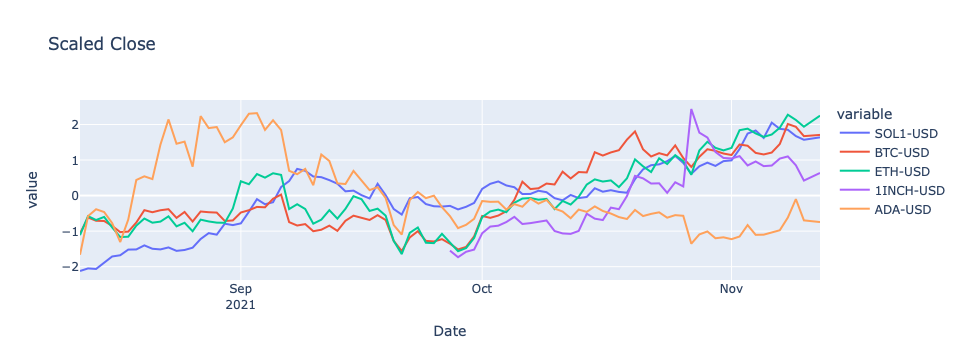

In [6]:
import plotly.express as px
#df = px.data.stocks()
fig = px.line(close_scaled, x="Date", y=close_scaled.columns,
              hover_data={"Date": "|%B %d, %Y"},
              title='Scaled Close')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()